In [ ]:
%%capture
!pip install mediapipe

In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

2024-04-21 04:58:29.365361: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 04:58:29.365414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 04:58:29.366929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [29]:
def create_image_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    return model

def create_landmarks_model(input_shape):
    model = models.Sequential()
    model.add(layers.Reshape((input_shape[0], input_shape[1]*input_shape[2])))

    model.add(layers.SimpleRNN(128, return_sequences=True))
    model.add(layers.Dropout(0.5))
    model.add(layers.SimpleRNN(64))
    return model

In [3]:
TRAINING_DIR = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
TESTING_DIR = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
CATEGORIES = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.75)

In [4]:
column_names = ["Image", "Label", "Landmarks"]
dataset = pd.DataFrame(columns=column_names)
path = TRAINING_DIR
print(f"starting with '{path}'")
for category in CATEGORIES:
    final_path = os.path.join(path, category)

    for imgdir in tqdm(sorted(os.listdir(final_path)), desc=f"{category}"):
        img_path = os.path.join(final_path, imgdir)
        img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
        new_array = cv2.resize(img_array, (128, 128))

        gray = cv2.cvtColor(new_array, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 2)
        th3 = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
        ret, threshold_image = cv2.threshold(th3, 70, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        mBlur_image = cv2.medianBlur(threshold_image, 5)

        image_rgb = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            landmarks = results.multi_hand_landmarks[0].landmark
            dataset.loc[len(dataset)] = {"Image": mBlur_image, "Label": category, "Landmarks": landmarks}
hands.close()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


starting with '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'


space: 100%|██████████| 3000/3000 [01:15<00:00, 39.62it/s]


In [7]:
dataset = dataset.sample(frac=1).reset_index(drop=True)

dataset.head()

,Image,Label,Landmarks
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",H,[x: 0.782427191734314\ny: 0.8360852003097534\n...
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...",C,[x: 0.3009406626224518\ny: 0.7786006927490234\...
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",B,[x: 0.656940221786499\ny: 0.8635324239730835\n...
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",B,[x: 0.36537623405456543\ny: 0.9142343997955322...
4,"[[0, 0, 255, 255, 255, 255, 255, 255, 255, 255...",N,[x: 0.39024972915649414\ny: 0.6255683898925781...


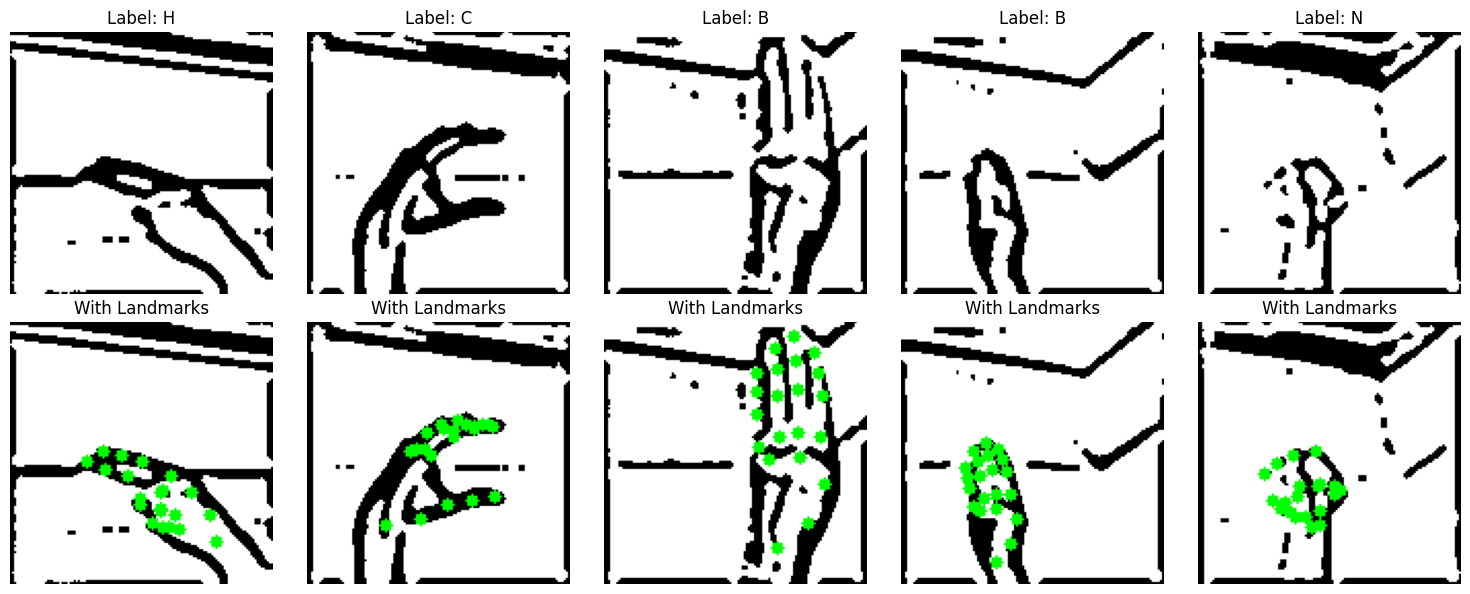

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    image = cv2.cvtColor(dataset.loc[i, 'Image'], cv2.COLOR_BGR2RGB)
    label = dataset.loc[i, 'Label']
    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Label: {label}')
    axes[0, i].axis('off')

    landmarks = dataset.loc[i, 'Landmarks']
    for landmark in landmarks:
        x = int(landmark.x * image.shape[1])
        y = int(landmark.y * image.shape[0])
        cv2.circle(image, (x, y), 3, (0, 255, 0), -1)
    axes[1, i].imshow(image)
    axes[1, i].set_title('With Landmarks')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
dataset['Landmarks'] = dataset['Landmarks'].apply(lambda landmarks: np.reshape(np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks]), (21, 3, 1)))

dataset['Landmarks'][0].shape

(21, 3, 1)

In [65]:
dataset.Label.value_counts()

Label
F          2902
Z          2867
J          2851
B          2841
G          2809
D          2780
L          2764
E          2762
K          2739
X          2738
A          2732
C          2718
W          2693
H          2668
V          2613
U          2590
R          2575
O          2507
Y          2505
S          2484
T          2479
I          2464
P          2438
Q          2317
space      1874
M          1842
N          1779
del        1743
nothing      14
Name: count, dtype: int64

In [12]:
train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=14, shuffle=True)

train_data.shape, test_data.shape

((63979, 3), (7109, 3))

In [19]:
X_train_images = np.array(train_data.Image.to_list()).reshape(len(train_data), 128, 128, 1)
X_train_landmarks = np.array(train_data.Landmarks.to_list()).reshape(len(train_data), 21, 3, 1)
y_train = train_data['Label'].to_numpy()

onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train = onehot_encoder.fit_transform(y_train)

X_train_images.shape, X_train_landmarks.shape, y_train.shape

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((63979, 128, 128, 1), (63979, 21, 3, 1), (63979, 29))

In [20]:
X_test_images = np.array(test_data.Image.to_list()).reshape(len(test_data), 128, 128, 1)
X_test_landmarks = np.array(test_data.Landmarks.to_list()).reshape(len(test_data), 21, 3, 1)
y_test = test_data['Label'].to_numpy()

y_test = y_test.reshape(len(y_test), 1)
y_test = onehot_encoder.transform(y_test)

X_test_images.shape, X_test_landmarks.shape, y_test.shape

((7109, 128, 128, 1), (7109, 21, 3, 1), (7109, 29))

In [ ]:
file_paths = {
    'X_train_images': 'X_train_images.pkl',
    'X_train_landmarks': 'X_train_landmarks.pkl',
    'y_train': 'y_train.pkl',
    'X_test_images': 'X_test_images.pkl',
    'X_test_landmarks': 'X_test_landmarks.pkl',
    'y_test': 'y_test.pkl'
}

for var_name, file_path in file_paths.items():
    var_value = locals()[var_name]
    with open(file_path, 'wb') as f:
        pickle.dump(var_value, f)

In [30]:
tf.keras.backend.clear_session()

image_input_shape = (128, 128, 1)
landmarks_input_shape = (21, 3, 1)

image_input = layers.Input(shape=image_input_shape)
image_model = create_image_model(image_input_shape)
image_output = image_model(image_input)

landmarks_input = layers.Input(shape=landmarks_input_shape)
landmarks_model = create_landmarks_model(landmarks_input_shape)
landmarks_output = landmarks_model(landmarks_input)

concatenated = layers.concatenate([image_output, landmarks_output])

dense_layer = layers.Dense(512, activation='relu')(concatenated)
dropout_layer = layers.Dropout(0.5)(dense_layer)

output_layer = layers.Dense(29, activation='softmax')(dropout_layer)

model = models.Model(inputs=[image_input, landmarks_input], outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 21, 3, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │    981,472 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64)        │     29,248 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     98,816 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 29)        │     14,877 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,124,413 (4.29 MB)

 Trainable params: 1,122,813 (4.28 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [31]:
history = model.fit([X_train_images, X_train_landmarks], y_train, epochs=10, validation_split=0.1)

Epoch 1/10
   3/1800 ━━━━━━━━━━━━━━━━━━━━ 1:54 63ms/step - accuracy: 0.0365 - loss: 4.1861 

W0000 00:00:1713678914.174854     202 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 120s 57ms/step - accuracy: 0.5518 - loss: 1.5033 - val_accuracy: 0.8078 - val_loss: 0.5582
Epoch 2/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 88s 49ms/step - accuracy: 0.9306 - loss: 0.2031 - val_accuracy: 0.7921 - val_loss: 0.6607
Epoch 3/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 87s 49ms/step - accuracy: 0.9543 - loss: 0.1310 - val_accuracy: 0.8868 - val_loss: 0.3519
Epoch 4/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 87s 49ms/step - accuracy: 0.9677 - loss: 0.1012 - val_accuracy: 0.8379 - val_loss: 0.7365
Epoch 5/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 88s 49ms/step - accuracy: 0.9730 - loss: 0.0833 - val_accuracy: 0.8167 - val_loss: 0.7790
Epoch 6/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 87s 48ms/step - accuracy: 0.9762 - loss: 0.0763 - val_accuracy: 0.7851 - val_loss: 1.2119
Epoch 7/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 87s 48ms/step - accuracy: 0.9774 - loss: 0.0708 - val_accuracy: 0.9417 - val_loss: 0.2346
Epoch 8/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 87s 48ms/step - accuracy: 0.9801 - loss: 0.0

In [32]:
loss, accuracy = model.evaluate([X_test_images, X_test_landmarks], y_test)
print(f'Validation loss: {loss}, Validation accuracy: {accuracy}')

223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9628 - loss: 0.1476
Validation loss: 0.16414707899093628, Validation accuracy: 0.9603319764137268


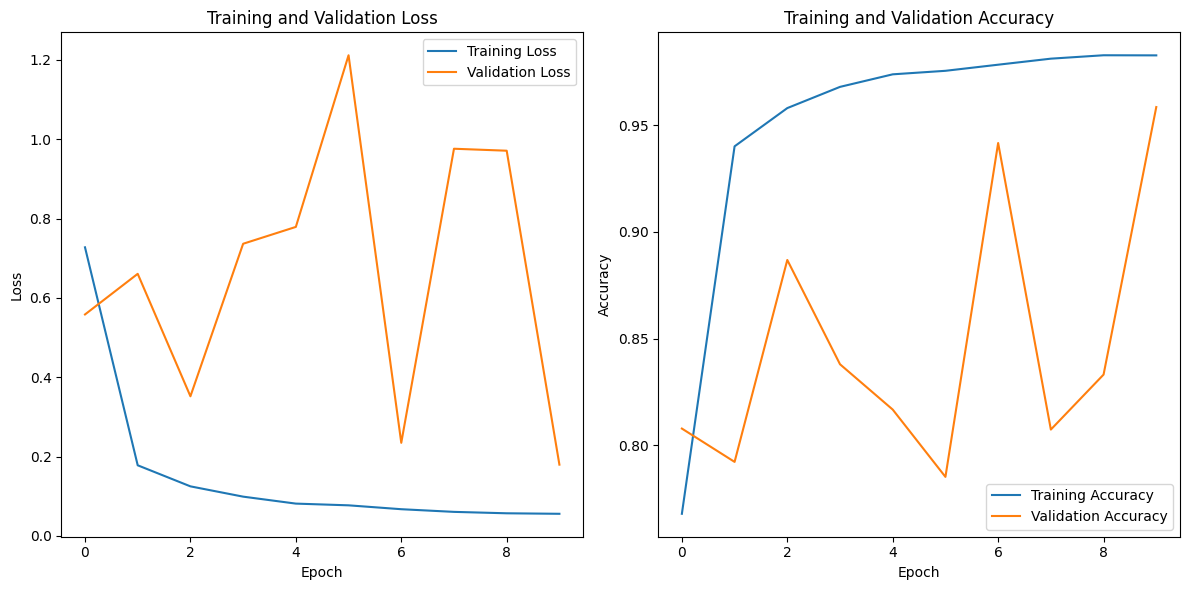

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.50, min_tracking_confidence=0.50)

print(f"reading from '{TESTING_DIR}'")
for imgdir in sorted(os.listdir(TESTING_DIR)):
    img_path = os.path.join(TESTING_DIR, imgdir)
    print(f"predicting: {img_path}")
    
    img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
    new_array = cv2.resize(img_array, (128, 128))

    gray = cv2.cvtColor(new_array, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 2)
    th3 = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    ret, threshold_image = cv2.threshold(th3, 70, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mBlur_image = cv2.medianBlur(threshold_image, 5)

    image_rgb = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        landmarks = np.reshape(np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks]), (21, 3, 1))
    else:
        print("couldnt extract landmarks")
        landmarks = np.ones((21, 3, 1)) 
    
    landmarks = np.expand_dims(landmarks, axis=0)
    mBlur_image = np.expand_dims(mBlur_image, axis=0)
    prediction = model.predict([mBlur_image, landmarks])
    prediction_label = onehot_encoder.categories_[0][np.argmax(prediction)]
    print(f"predicted: {prediction_label}")
        
hands.close()

reading from '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
predicting: /kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg
couldnt extract landmarks
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted: I
predicting: /kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/B_test.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predicted: B
predicting: /kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/C_test.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted: C
predicting: /kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/D_test.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted: D
predicting: /kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/E_test.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted: E
predicting: /kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/F_test.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted: F
predicting: /kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test

In [69]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.weights.h5")